# Evrişimli Sinir Ağları(CNN) ile Katı Atık Tespiti


1.   İş Problemi (Business Problem)
2.   Veriyi Anlamak (Data Understanding)
3.   Veriyi Hazırlamak (Data Preparation)
4.   Modelleme (Modelling)
5.   Değerlendirme (Evaluation)

# 1. İş Problemi (Business Problem)

**İş Problemi Nedir?**

Katı atık tespiti yapılmak istenmektedir. Bunu yapay sinir ağları ile bir model tanımlayıp yapabiliriz. Bunun için modelimizi örnek resimler ile eğiteceğiz ve yeni bir resim geldiğinde bunun hangi kategoriye girdiğini makine öğrenimi aracılığıyla ayırt etmiş olacağız.

# 2. Veriyi Anlamak (Data Understanding)

## 2.1. Veri Seti Hikayesi

Bu proje kapsamında kullanacağımız veri seti TrashNet isimli veri setidir. Stanford Üniversitesi öğrencileri tarafından hazırlanmıştır. Veri seti altı farklı sınıftan oluşmaktadır. Veri setinde Cam, Kağıt, Karton, Plastik, Metal ve Çöp olmak üzere toplamda 2527 adet görüntü bulunmaktadır.

Görüntülerin dağılımı:


*   491 cam
*   584 kağıt
*   393 karton
*   472 plastik
*   400 metal
*   127 çöp

Görüntüler, beyaz bir panoya yerleştirilerek ve güneş ışığı veya oda aydınlatılması kullanılarak çekilmiştir. Görüntüler, 512 x 384 piksel boyutlarında ve 3 (RGB) kanallıdır.

## 2.2. Gerekli Kütüphanelerin Import İşlemleri

In [1]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=b4261c1e196c8345a6c3378b2750795f67011e23861d86efb7addf05522fdffe
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Veriyi okma ve işleme adımında kullanılacak olan kütüphaneler
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Warningleri kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings('ignore')

# Model değerlendirme için kullanılacak olan kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report

# Model için kullanılacak olan kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img


## 2.3. Veri Setinin Okunması

In [4]:
# Görsellerin bulunduğu dizin
dir_path = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification/'

In [5]:
'''
target_size ve labels değişkenlerini tanımlayacağız.
target_size, datasetindeki resimlerin yeni boyutları olacak.
labels ise çıkış katmanındaki sonuç bilgisi olacak yani resimleri etiketlediğimiz bilgiyi burada tutacağız.
labels bilgisi aynı zamanda klasör isimleride olduğu için klasörlerden resimleri çekerken modelimizin
hangi resmin ne olduğunu öğrenebilmesi için bu bilgiyi resim etiketleme amacıyla kullanacağız.
'''

target_size = (224, 224)

waste_labels = {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [6]:
def load_datasets(path):
    '''
    Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.
    
    Parametreler:
    path: Görsellerin bulunduğu dizini ifade eder.
    
    Return:
    x: Görüntülere ait matis bilgilerini tutar.
    labels: Görüntünün ait olduğu sınıf bilgisini tutan liste.
    '''
    
    x = []
    labels = []
    
    # Gönderdiğimiz pathdeki görüntüleri listeleyip sıralamaktadır.
    image_paths = sorted(list(paths.list_images(path)))
    
    for image_path in image_paths:
        # Belirtilen pathdeki görüntüler openCV kütüphanesi ile okunmaktadır.
        img = cv2.imread(image_path)
        
        # Okunan görüntüler başlangıçta belirlenen target_size'a göre yeniden ölçeklendirilir.
        img = cv2.resize(img, target_size)
        
        # Ölçeklendirilen görüntüler x listesine eklenir.
        x.append(img)
        
        # Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labelı temsil etmektedir.
        label = image_path.split(os.path.sep)[-2]
        
        # Yakalanan labelların sayısal değer karşılıklarının olduğu waste_labels sözlüğü içerisinden gönderilen
        # key değerine karşılık value değeri alınarak label oluşturulur.
        labels.append(waste_labels[label])
        
    # Veri seti random bir şekilde karıştırılır. Nedeni modelin buradaki ardışıklıktan bir öğrenme yapmasını engellemektir.
    x, labels = shuffle(x, labels, random_state=42)
    
    # Boyut ve Sınıf Bilgisi raporlanmaktadır.
    print(f'X boyutu: {np.array(x).shape}')
    print(f'Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}')
    
    return x, labels

In [7]:
# Okuma işlemini yapıyoruz.
x, labels = load_datasets(dir_path)

X boyutu: (2527, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 2527


In [8]:
# Görüntü boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


## 2.4. Veri Setinden Örnekler Gösterilmesi

In [9]:
def visualize_img(image_batch, label_batch):
    '''
    Veri seti içersinden görüntü görselleştirir.
    
    Parametreler:
    image_batch: Görüntülere ait matis bilgilerini tutar.
    label_batch: Görüntünün ait olduğu sınıf bilgisini tutan liste.
    '''
    
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
        plt.axis('off')

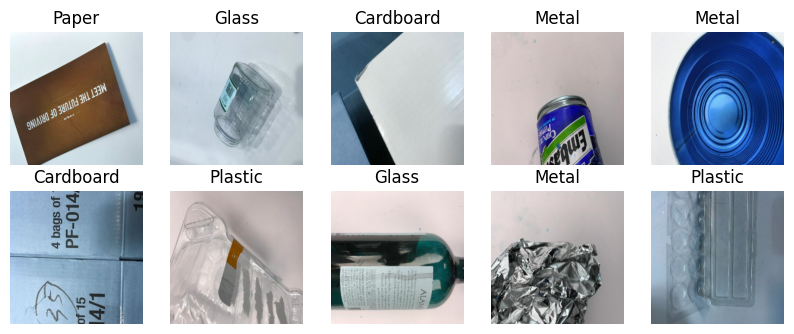

In [10]:
visualize_img(x, labels)

# 3. Veriyi Hazırlamak (Data Preparation)

Veriyi modellemeye hazırlarken ek olarak gerçek dünya özellikleri ekleme işleminide yapacağız. Gerçek dünyada görüntülerde gürültü olacağı düşünülerek elimizdeki resimlere gürültü ekleyerek biraz daha gerçekçi bir veri seti oluşturmayı hedeflemekteyiz.

In [11]:
# Train veri seti için bir generator tanımlıyoruz.
train = ImageDataGenerator(horizontal_flip=True,   # Görüntüleri rastgele yatay olarak çevirir
                           vertical_flip=True,     # Görüntüleri rastgele dikey olarak çevirir
                           validation_split=0.1,   # Test veri setinin oranı
                           rescale=1./255,         # Yeniden ölçeklendirme faktörü, defaultu None, Pikselleri 0 ila 1 arasına ölçeklendirme
                           shear_range=0.1,        # Görüntünün şekline eğim verir
                           zoom_range=0.1,         # Zoomlama
                           width_shift_range=0.1,  # Genişlik kaydırma
                           height_shift_range=0.1) # Yükseklik kaydırma

# Test veri seti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

In [12]:
train_generator = train.flow_from_directory(directory=dir_path,         # Resimlerin olduğu dizin
                                            target_size=(target_size),  # Resimlerin boyut bilgisi
                                            class_mode='categorical',   # Sınıflandırma problemi old. belirtiyoruz, eğer ikili bir sınıflandırma yapsaydık binary yazmamız gerekecekti
                                            subset='training')          # ImageDataGenerator'da validation_split değişkeni girilmişse burada bir subset belirtilmesi gerekmektedir

test_generator = test.flow_from_directory(directory=dir_path,
                                          target_size=(target_size),
                                          batch_size=251,               # Veri gruplarının boyutu, subsample gibi
                                          class_mode='categorical',
                                          subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


# 4. Modelleme (Modelling)

## 4.1. Sıfırdan CNN Modeli Kurma

* Sequential
* Evrişim Katmanı (Convolution Layer, Conv2D)
* Havuzlama Katmanı (Pooling Layer)
* Aktivasyon Fonksiyonu Katmanı (Activation Layer)
* Flattening Katmanı
* Dense Katmanı
* Dropout Katmanı

In [13]:
model = Sequential() # Sıralı katmanlardan oluşan bir sinir ağı oluşturma

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
# Evrişim katmanı, bu katman ile giriş görüntüsü üzerinden çeşitli filtreler aracılığıtla öznitelik çıkarımı yapıyor olacağız.
# filters: Bir görüntü üzerinde gezdirilecek olan filtre sayısı
# kernel_size: 3x3 lük filtre kullanılacak
# padding: gercek resim ile aynı boyutta bir çıktı elde edilsin, giriş resminin kenarlarına eklemeler yapılır
# input_shape: giriş verileri
# activation: aktivasyon fonksiyonu relu, yani insan beynine en çok benzeyen fonksiyon seçildi. Aktivasyon fonksiyonu katmanı görevi bu parametre ile yapılır.

model.add(MaxPooling2D(pool_size=2, strides=(2,2)))
# Havuzlama Katmanı, görüntünün özelliklerini kaybetmeden boyutunun azaltılması işlemidir. Downsampling olarakta bilinir
# Bu katmanda herhangi bir öğrenme işlemi yapılmamaktadır. Evrişim katmanı sonrası kullanılır.
# MaxPooling2D, gezilen matristeki maksimum değer alınarak maksimum matrisi oluşturur
# pool_size, görüntü üzerinde gezdirilecek filtrenin boyutu
# Evrişim katmanındaki yoğun işlem ihtiyacını azaltma amacıyla kullanılmaktadır

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))
# 2 adet daha evrişim ve havuzlama katmanı ekledik. Bu bir hiperparametre optimizasyonu konusudur ve deneme yanılma yöntemi ile bu ekleme çıkarmalar yapılır.

model.add(Flatten())
# Verileri YSA girişine uygun hale getirmek için kullanılır. Evrişim katmanından gelen matrisleri tek boyutlu dizilere çevirir.

model.add(Dense(units=32, activation='relu'))
# Dense katmanı, katmanlar arasında nöron yada düğümlerin geçişlerini sağlamaktadır. Yani bir katmandan aldığı nöronların bir sonraki nörona bağlanmasını sağlar.
# units: nöron sayısı
# activation: aktivasyon fonksiyonu

model.add(Dropout(rate=0.2))
# Aşırı öğrenmenin önüne geçmek için, yani overfitting'i engellemek için kullanılan bir argümandır.
# Sinir ağında bulunan nöronların parametre ile belirtildiği oranda rastgele söndürülmesiyle yapılır.
# Performansı arttırır

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation='softmax'))
# Çıktı katmanıdır. Aktivasyon fonksiyonu 2den fazla sınıflandırma problemi olduğu için softmax kullanılmaktadır.

## 4.2. Model Özeti

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

## 4.3. Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması

### 4.3.1. model.compile

Modeli derlemeden yani fit etmeden önce modeli bunlara göre derle bilgisini yani optimizasyon ve değerlendirme paratmerelerini ayarlayacağız

In [15]:
model.compile(loss='categorical_crossentropy',
              # Odaklanılacak loss fonksiyonu, 2'den fazla sınıf olduğu için bu kullanılır fakat
              # 2 sınıf olsaydı binary_crossentropy kullanılacaktı
              
              optimizer='adam',
              # categorical_crossentropy'i minimize edecek optimizasyon yöntemidir,
              # en çok kullanılan adam'dır diğerleride denenebilir
              
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'acc'])
              # modelin başarısını ölçeceğimiz metrikler

### 4.3.2. callbacks

Sinir ağını eğitirken iterasyonları kaydetmek, gerektiğinde earlystopping kontrolünü
yapmak, model bilgilerini kaydetmek için callbacks adında bir liste oluşturulur.
Bu liste içinde EarlyStopping ve ModelCheckpoint bilgileri girilir.

* EarlyStopping: Model ezberlemeye başlama sinyalleri verdiğinde durmayı ifade eder.
    * monitor: Aşırı öğrenmeyi hangi metrik ile takip edeceğimizi belirliyoruz.
    * patience: Kaç adımda(eopchta) ilerleme olmazsa duracağımızı sayısal olarak belirliyoruz.
    * verbose: 0, 1, 2 alır. 0: log çıkmaz, 1: progress bar ile bilgi, 2: her epochta bilgi
    * mode: Model gelişiminin takip edileceği parametre değerleridir. min, max ve auto girilebilir.
        * min: monitor edilen değerin düşüşü durduğunda,
        * max ise artışı durduğunda tetiklemeyi sağlar.
        * auto: izlenen yön gidişe göre otomatik olarak belirlenir.

* ModelCheckpoint: Model öğrenimi devam ederken en iyi modelin kaydedilmesini sağlar.
    * filepath: Modeli hangi isimle ve uzantıyla kaydedeceğimizi belirliyoruz.
    * monitor: Odaklanılacak aşırı öğrenme metriği
    * mode: Odaklanılacak mode bilgisi
    * save_best_only: Sadece en iyi modeli kaydetmeyi sağlar
    * save_weights_only: Sadece ağırlıkları kaydetmeyi sağlar

In [16]:
callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min'),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)]

## 4.4. Modelin Eğitilmesi

### 4.4.1 model.fit_generator

* generator: Resimlerin dizin, boyut, sınıflandırma problemi ve batch_size gibi bilgilerini train_generator nesnesi yardımıyla modele tanımlıyoruz.
* epochs: Model eğitilirken verilerin modelden kaç defa geçirilecğini, kaç iterasyon yapılacağını kısaca verinin kaç defa öğrenme sürecinden geçirileceğini belirttiğimiz sayıdır. Kaç olacağı deneme yanılma ile belirlenmesi gerekmektedir. Fakat erken durma ayarlaması yapıldıysa bu sayı çok yüksek bir sayı yapılıp modelin en iyi anında durmasıda beklenebilir.
* validation_data: train_generator ile verilen train dizin, boyut vb. bilgilerin test için olanıdır.
* callbacks: Modelin erken durma ve en iyi modelin kaydedilmesi gibi ayarlamaların girildiği yerdir.
* workers: Paralel olarak gruplar oluşturan iş parçacığı sayısıdır. Gruplar CPU'da paralel olarak hesaplanır ve yapay zeka hesaplamaları için anında GPU'a iletilir. Donanımsal bir parametredir.
* steps_per_epoch: Bir epouchun tamamlandığını ve bir sonraki epochun başladığını bildirmeden önceki toplam adım sayısını ifade eder. 2276 adet resimden 32'de 1'i kadarı yani 71 adet kadar resim epochta işlendikten sonra 1 epoch tamamlandı kabul edilebilirin ifadesidir. Subsample'ın aynısıdır.
* validation_steps: steps_per_epoch'un validation yani test seti için olan 1 epochun tamamlanması için sinir ağında işlenecek resim sayısını ifadece eder.

In [17]:
history = model.fit_generator(generator=train_generator,
                              epochs=100,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              workers=4,
                              steps_per_epoch=2276//32,
                              validation_steps=251//32)

Epoch 1/100


I0000 00:00:1708348009.508556     145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 [==============================] - ETA: 0s - loss: 1.6743 - precision: 0.6719 - recall: 0.0383 - acc: 0.2843
Epoch 1: val_loss improved from inf to 1.52133, saving model to mymodel.h5
71/71 [==============================] - 33s 340ms/step - loss: 1.6743 - precision: 0.6719 - recall: 0.0383 - acc: 0.2843 - val_loss: 1.5213 - val_precision: 0.9412 - val_recall: 0.0637 - val_acc: 0.3586
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.5028 - precision: 0.7567 - recall: 0.1136 - acc: 0.3743
Epoch 2: val_loss improved from 1.52133 to 1.43003, saving model to mymodel.h5
71/71 [==============================] - 20s 276ms/step - loss: 1.5028 - precision: 0.7567 - recall: 0.1136 - acc: 0.3743 - val_loss: 1.4300 - val_precision: 0.8529 - val_recall: 0.1155 - val_acc: 0.4064
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.4271 - precision: 0.7179 - recall: 0.1497 - acc: 0.4180
Epoch 3: val_loss improved from 1.43003 to 1.39241, saving model to m

## 4.5. Accuracy ve Loss Grafikleri

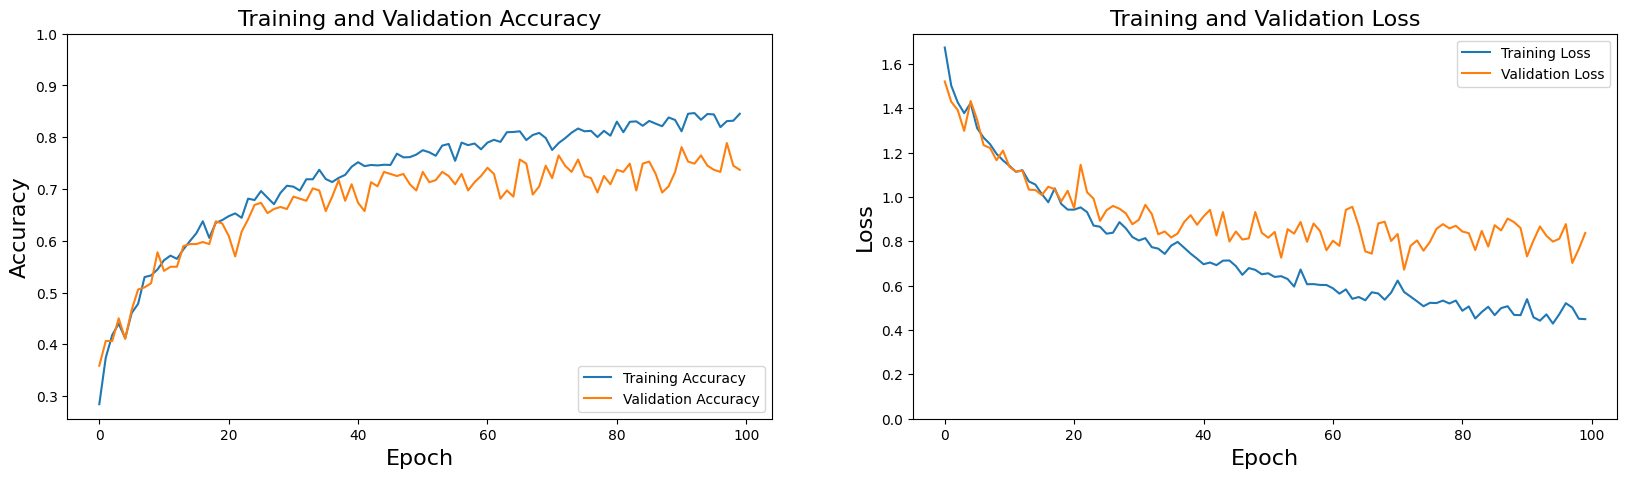

In [18]:
# Accuracy Grafiği
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

# 5. Değerlendirme (Evaluation)

## 5.1. model.evaluate ile Değerlendirme

In [31]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

1/1 [==============================] - 1s 1s/step - loss: 0.8378 - precision: 0.8075 - recall: 0.6853 - acc: 0.7371


In [20]:
print(f'\nTest Accuracy: %.1f%%' % (100.0 * acc))
print(f'\nTest Loss: %.1f%%' % (100.0 * loss))
print(f'\nTest Precision: %.1f%%' % (100.0 * precision))
print(f'\nTest Recall: %.1f%%' % (100.0 * recall))


Test Accuracy: 73.7%

Test Loss: 83.8%

Test Precision: 80.8%

Test Recall: 68.5%


## 5.2. Sınıflandırma Raporu (Classification Report)

Modeli kullanarak test veri setini sorup labelları tahmin etme işlemini yapacağız. Bu sonuçlara göre bir sınıflandırma raporu oluşturacağız.

In [21]:
x_test, y_test = test_generator.next()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1) # predlerin içerisinden maksimumları alma işlemi

y_test = np.argmax(y_test, axis=1) # y_test'in sınıf cinsinden değerlerini alma işlemi

8/8 [==============================] - 1s 112ms/step


In [22]:
target_names = list(waste_labels.keys()) # hedef değişkenin sınıflarına erişme

In [23]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.87      0.68      0.76        40
       glass       0.81      0.78      0.80        50
       metal       0.51      0.88      0.64        41
       paper       0.91      0.83      0.87        59
     plastic       0.75      0.56      0.64        48
       trash       0.64      0.54      0.58        13

    accuracy                           0.74       251
   macro avg       0.75      0.71      0.72       251
weighted avg       0.77      0.74      0.74       251



## 5.3. Karmaşıklık Matrisi (Confusion Matrix)

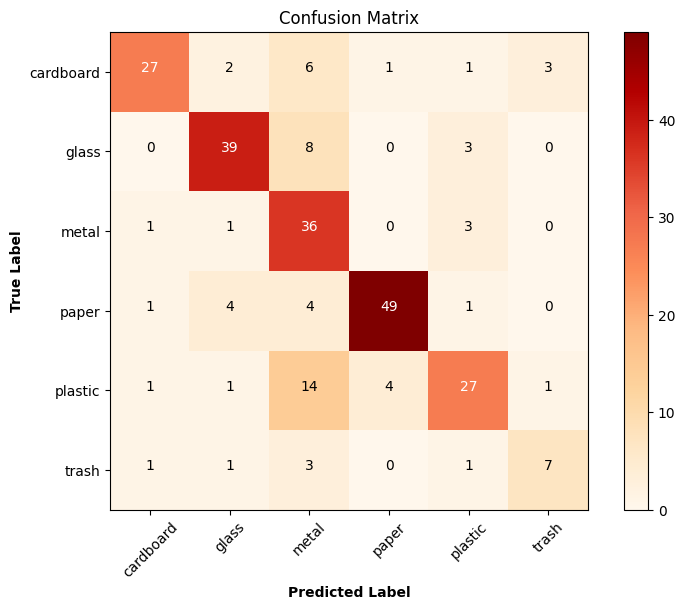

In [24]:
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion Matrix',
                      cmap=plt.cm.OrRd)

Yukarıdaki grafikte true label ekseninde plastic satırında 14 rakamına odaklanacak olursak; plastic olan 14 resme metal dediğimizi görürüz. Aynı şekilde glass olan 8 resme metal demişiz. Bu noktalara odaklanarak modelimizi tekrardan ele alıp daha doğru sonuçlar elde edebiliriz.

## 5.4. Kaydedilmiş Modeli Yeniden Yükleme

In [25]:
# Ağırlıkları ve optimizerda dahil olmak üzere aynı modeli yeniden oluşturun
new_model = tf.keras.models.load_model('/kaggle/working/mymodel.h5')

# Model mimarisini gösterin
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

In [30]:
# Yeniden yüklenen modeli kontrol et
new_loss, new_precision, new_recall, new_acc = new_model.evaluate(test_generator, batch_size=32)

1/1 [==============================] - 1s 1s/step - loss: 0.6723 - precision: 0.8357 - recall: 0.6892 - acc: 0.7649


## 5.5. Modelin Yeni Veriler ile Test Edilmesi

1/1 [==============================] - 0s 18ms/step


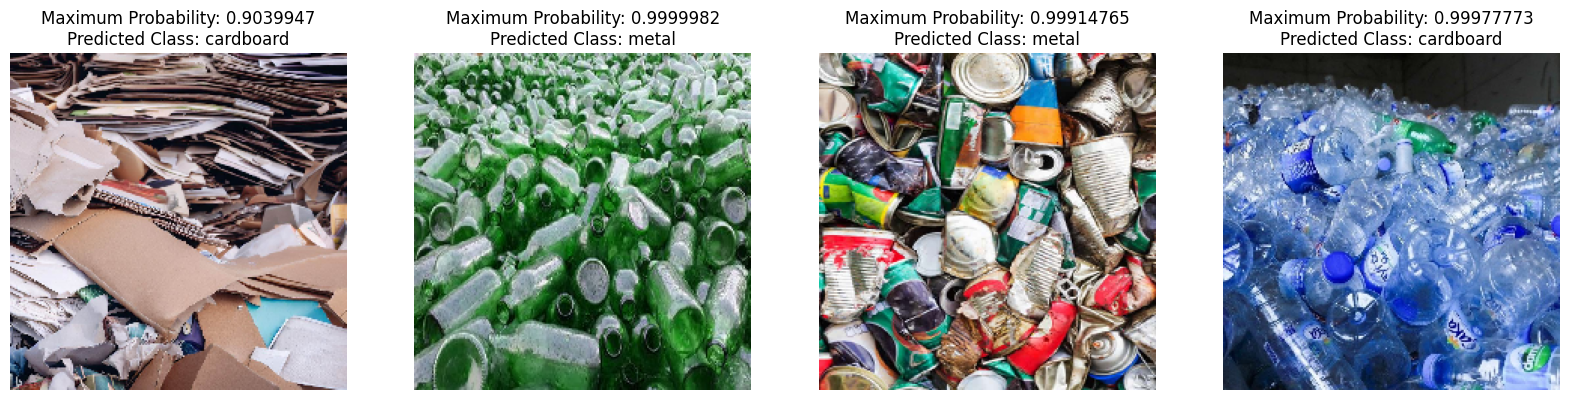

In [46]:
waste_labels2 = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}
# target_size = (224, 224)

def model_testing(path):
    '''
    Görsellerin bulunduğu dizindeki görüntüyü okuyup model aracılığı ile hangi sınıfa ait
    olduğuna dair tahmin işlemi gerçekleştirilir.
    
    Parametreler:
    path: Görsellerin bulunduğu dizini ifade eder.
    
    Return:
    img: Görüntü
    p: Tahmin olasılıkalrı
    predicted_class: Tahmin sınıfı
    '''
    img = image.load_img(path, target_size=(target_size))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0
    p = new_model.predict(img.reshape(1, 224, 224, 3)) # p = model.predict(img.reshape(1, 224, 224, 3))
    predicted_class = np.argmax(p[0])
    
    return img, p, predicted_class

img1, p1, predicted_class1 = model_testing('/kaggle/input/new-test-data2/cardboard_test_003.jpg')
img2, p2, predicted_class2 = model_testing('/kaggle/input/new-test-data2/glass_test_003.jpg')
img3, p3, predicted_class3 = model_testing('/kaggle/input/new-test-data2/metal_test_002.jpg')
img4, p4, predicted_class4 = model_testing('/kaggle/input/new-test-data2/plastic_test_003.jpg')

plt.figure(figsize=(20, 60))

plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p1[0], axis=-1)) + '\n' + 'Predicted Class: ' + str(waste_labels2[predicted_class1]))
plt.imshow(img1);

plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p2[0], axis=-1)) + '\n' + 'Predicted Class: ' + str(waste_labels2[predicted_class2]))
plt.imshow(img2);

plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p3[0], axis=-1)) + '\n' + 'Predicted Class: ' + str(waste_labels2[predicted_class3]))
plt.imshow(img3);

plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title('Maximum Probability: ' + str(np.max(p4[0], axis=-1)) + '\n' + 'Predicted Class: ' + str(waste_labels2[predicted_class4]))
plt.imshow(img4);
